In [1]:
import string
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

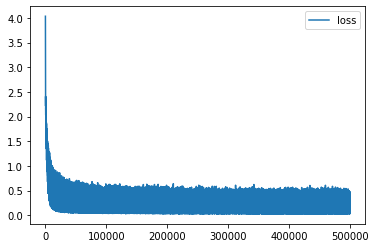

In [26]:
with open('sonnets_upd.txt', 'r') as iofile:
    text = iofile.readlines()
  
text = text

res = ''
for line in text:
  res += line
text = res.lower()

tokens = sorted(set(text))

# словарь вида <индекс>:<символ>
token_to_idx = {}
i = 0
for symbol in tokens:
  token_to_idx[symbol] = i
  i += 1

# словарь вида <символ>:<индекс>
idx_to_token = {y:x for x,y in token_to_idx.items()}

num_tokens = len(tokens) 


class CharLSTMLoop_hidden(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.hidden_dim = rnn_num_units
        
    def forward(self, x, hidden):
        # assert isinstance(x.data, torch.LongTensor)
        h_seq, hidden = self.lstm(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden 
        

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(1, batch_size, self.hidden_dim).zero_(),
                      weight.new(1, batch_size, self.hidden_dim).zero_())
        return hidden
    
model = CharLSTMLoop_hidden()
if (torch.cuda.is_available()):
  model = model.cuda()
  
opt = torch.optim.Adam(model.parameters())

seq_size=32
batch_size=16




idx_text = [token_to_idx[w] for w in text]
num_batches = len(idx_text) // (seq_size * batch_size)
in_text = idx_text[:num_batches * batch_size * seq_size]
out_text = np.zeros_like(in_text)
out_text[:-1] = in_text[1:]
out_text[-1] = in_text[0]

in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))


history = []


h = model.init_hidden(batch_size)
for i in range(500000):
    i = random.randint(0, num_batches)
    batch_ix = in_text[:, i:i+seq_size]
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    if (torch.cuda.is_available()):
      batch_ix = batch_ix.cuda()

    # print(batch_ix.size())
    #h.detach_()
    if (torch.cuda.is_available()):
      h = tuple([e.data.cuda() for e in h])
    else:
      h = tuple([e.data for e in h])


    logp_seq, h = model(batch_ix, h)


    
    # compute loss

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    
    
    # train with backprop

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

    loss = -logp_next.mean()
    loss.backward()
    opt.step()
    opt.zero_grad()
    if (torch.cuda.is_available()):
      history.append(loss.cpu().data.numpy())
    else:
      history.append(loss.data.numpy())
    
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        torch.save(model.state_dict(), 'model_lstm_hidden.pth')
        torch.save(opt.state_dict(), 'optimizer_lstm_hidden.pth')

In [ ]:
model = CharLSTMLoop_hidden()
model.load_state_dict(torch.load('/content/model_lstm_hidden.pth'))

In [27]:
def generate_text_hidden(length, initial = ' ', temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    
    
    x_sequence = [token_to_idx[token] for token in initial]
    
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).unsqueeze(0)

    if (torch.cuda.is_available()):
      x_sequence = x_sequence.cuda() 
    
    
    h = model.init_hidden(1)

    #start generating
    for _ in range(length):

        #________________________________
        # NOTE THAT  x_sequence[ :, :, -1] IS the last symbol of the sequence
        # u can easily check it with print fuction
        #________________________________

        h = tuple([e.data for e in h])

        logp_next, h = model(x_sequence[ :, :, -1], h)
       
        #print( x_sequence[ :, :, -1].data.numpy()) 
        if (torch.cuda.is_available()):
          p_next = F.softmax(logp_next / temperature, dim=-1).cpu().data.numpy()[0][-1]
        else:
          p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][-1]
        

        #print(str(p_next)+ '\n' )
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p = p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        if (torch.cuda.is_available()):
          next_ix = next_ix.cuda()
        x_sequence = torch.cat([x_sequence[:, -1], next_ix], dim=1)
        x_sequence = x_sequence.unsqueeze(0)
        #print('_______END_OF_CURRENT_ITER_____________')
    
    if (torch.cuda.is_available()):
          return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0][0]])
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [28]:
print(str(generate_text_hidden(500)))

  doth that plea deny,
  anden of your don of inconstant mind,
  sides thus is simple truth moon and sun,
  and loaths your graces and your gifts to tell;
    and bristly presagers of my look for recompense,
  more than that tongue that more hath more express'd.
    o! learn to read what silent of thine own,
  in other accents do this praise on thy revolt doth lie.
  o! what a happy title do i find,
  happy to whose that can see thou atenge decrees of kings,
  tan sacred beauty, blunt the sharp's
